# Tree species classification project -- Data Science of Earth Oberservation
Group members:


Input file: .npy

In [136]:
# import the libraries you need

import os
import math
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from matplotlib.image import imread
from itertools import product
from PIL import Image
from itertools import chain
import json
from jsonpath import jsonpath 
import scipy.ndimage
from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import type_of_target

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
import torch
# Folium setup.
import folium

# Step 1. Input the npy data

In [60]:
# get all npy files
## The ratio can also be changed
path= '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Data science of earth observation/Project_data_science/data0205/npy/'
test_path='/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Data science of earth observation/Project_data_science/test_data_indices_0203/'
split_ratio = 0.8
dir_samples = path + "/*.npy"
samples = glob.glob(dir_samples)

# merge them
t_samples = np.load(samples[0], allow_pickle=True)

for i, p in tqdm(enumerate(samples[1:])):
    try:
        t_samples = np.concatenate(
            (t_samples, np.load(p, allow_pickle=True))
        )
    except Exception:
        print(p)
        
np.random.shuffle(t_samples,)

train_num = int(len(t_samples)*split_ratio)

t_sample = t_samples[:train_num]
v_sample = t_samples[train_num:]


# define the train/valid path
t_samples_merge_path = path + "merge/train_merge.npy"
v_samples_merge_path = path + "merge/val_merge.npy"

np.save(t_samples_merge_path, t_sample)
np.save(v_samples_merge_path, v_sample)

print("Now all merge samples are saved!")

4it [00:00, 10.28it/s]


Now all merge samples are saved!


In [61]:
# get all npy files
## The ratio can also be changed


t_dir_samples = test_path + "/*.npy"
te_samples = glob.glob(t_dir_samples)

# merge them
test_samples = np.load(te_samples[0], allow_pickle=True)

for i, p in tqdm(enumerate(te_samples[1:])):
    try:
        test_samples = np.concatenate(
            (test_samples, np.load(p, allow_pickle=True))
        )
    except Exception:
        print(p)
        
np.random.shuffle(test_samples,)


# define the train/valid path
test_samples_merge_path = test_path + "merge/test_merge.npy"

np.save(test_samples_merge_path, test_samples)

print("Now all merge samples are saved!")


4it [00:00, 102.56it/s]

Now all merge samples are saved!


# Step 2. Data preparation

In [62]:
train_merge = np.load(t_samples_merge_path,allow_pickle=True)
val_merge = np.load(v_samples_merge_path,allow_pickle=True)
print (np.array(train_merge).shape)
print (np.array(val_merge).shape)
test_merge = np.load(test_samples_merge_path,allow_pickle=True)
print (np.array(test_merge).shape)

(2784, 1, 2)
(697, 1, 2)
(495, 1, 2)


In [133]:
kernel=24
bands=45
minkernel=36
input_size=( minkernel,minkernel,bands)
output_size = 5+1
number_samples = train_merge.shape[0]
data_train = train_merge[:,:,0]

X_train= np.zeros((number_samples,  kernel,kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train[i,:] = data_train[i,0]

Y_train = np.reshape(train_merge[:,:,1],number_samples).astype(int)
X_train_rf = np.reshape(X_train, (number_samples,  kernel*kernel*bands))
X_train_rf= np.array(pd.DataFrame(X_train_rf).fillna(0))
print("Post-processed S2_train data shape: ", X_train_rf.shape)



Post-processed S2_train data shape:  (2784, 25920)


In [64]:

number_samples = val_merge.shape[0]
data_val = val_merge[:,:,0]
X_val= np.zeros((number_samples,   kernel,kernel,bands), dtype=float)

for i in range(0,number_samples-1):
    X_val[i,:] = data_val[i,0]

Y_val = np.reshape(val_merge[:,:,1],number_samples).astype(int)
X_val_rf = np.reshape(X_val, (number_samples, kernel*kernel*bands))
X_val_rf= np.array(pd.DataFrame(X_val_rf).fillna(0))
print("Post-processed S2_val data shape: ", X_val_rf.shape)

Post-processed S2_val data shape:  (697, 25920)


In [65]:

number_samples = test_merge.shape[0]
data_test = test_merge[:,:,0]
X_test= np.zeros((number_samples,   kernel,kernel,bands), dtype=float)

for i in range(0,number_samples-1):
    X_test[i,:] = data_test[i,0]

Y_test = np.reshape(test_merge[:,:,1],number_samples).astype(int)
X_test_rf = np.reshape(X_test, (number_samples, kernel*kernel*bands))

print("Post-processed S2_val data shape: ", X_test_rf.shape,X_test.shape)

Post-processed S2_val data shape:  (495, 25920) (495, 24, 24, 45)


# Step 3. Random forest classification

Random Forest: Random Forest is a supervised learning algorithm, it can be used to classify tree species using Sentinel-2 imagery.

In [66]:
rf_classifier = RandomForestClassifier(random_state=0)

rf_classifier.fit(X_train_rf, Y_train)

RandomForestClassifier(random_state=0)

In [67]:
y_pred_rf = rf_classifier.predict(X_val_rf)

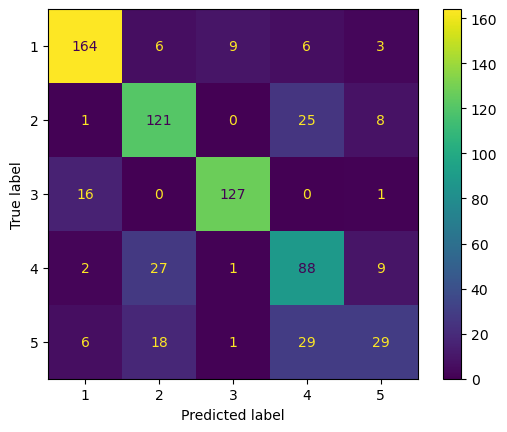

Accuracy Random Forest Classifier:  0.7589670014347202


In [68]:
ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rf)
plt.show()

acc_rf = accuracy_score(Y_val, y_pred_rf)
print("Accuracy Random Forest Classifier: ", acc_rf)

# Step 4. Artificial Nueral Network (ANN) classification

In [69]:
number_samples = X_train.shape[0]
X_train_nn= np.zeros((number_samples,  kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train_nn[i,:] = np.reshape(X_train[i,:], (  kernel*kernel,bands))
    X_train_nn[i,:]= np.array(pd.DataFrame(X_train_nn[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_train_nn.shape)

Post-processed S2_train data shape:  (2784, 576, 45)


In [70]:
number_samples = X_val.shape[0]
X_val_nn= np.zeros((number_samples,   kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_val_nn[i,:] = np.reshape(X_val[i,:], (  kernel*kernel,bands))
    X_val_nn[i,:]= np.array(pd.DataFrame(X_val_nn[i,:]).fillna(0))
print("Post-processed S2_val data shape: ", X_val_nn.shape)

Post-processed S2_val data shape:  (697, 576, 45)


In [72]:
number_samples = X_test.shape[0]
X_test_nn= np.zeros((number_samples,   kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_test_nn[i,:] = np.reshape(X_test[i,:], (  kernel*kernel,bands))
    X_test_nn[i,:]= np.array(pd.DataFrame(X_test_nn[i,:]).fillna(0))
print("Post-processed S2_test data shape: ", X_test_nn.shape)

Post-processed S2_test data shape:  (495, 576, 45)


In [138]:

number_samples = X_train.shape[0]
X_train_nn2= np.zeros((number_samples,  minkernel,minkernel,bands), dtype=float)
for i in range(0,number_samples-1):
    for j in range(0,45):
        tile= np.array(X_train[i,:,:,j])
        X_train_nn2[i,:,:,j]= scipy.ndimage.zoom(tile, 1.5, order=1)
print("Post-processed S2_train data shape: ", X_train_nn2.shape)

Post-processed S2_train data shape:  (2784, 36, 36, 45)


In [139]:

number_samples = X_val.shape[0]
X_val_nn2= np.zeros((number_samples,  minkernel,minkernel,bands), dtype=float)
for i in range(0,number_samples-1):
    for j in range(0,45):
        tile= np.array(X_val[i,:,:,j])
        X_val_nn2[i,:,:,j]= scipy.ndimage.zoom(tile, 1.5, order=1)
print("Post-processed S2_train data shape: ", X_val_nn2.shape)

Post-processed S2_train data shape:  (697, 36, 36, 45)


In [202]:

number_samples = X_test.shape[0]
X_test_nn2= np.zeros((number_samples,  minkernel,minkernel,bands), dtype=float)
for i in range(0,number_samples-1):
    for j in range(0,45):
        tile= np.array(X_test[i,:,:,j])
        X_test_nn2[i,:,:,j]= scipy.ndimage.zoom(tile, 1.5, order=1)
print("Post-processed S2_train data shape: ", X_test_nn2.shape)

Post-processed S2_train data shape:  (495, 36, 36, 45)


In [150]:
base_model =tf.keras.applications.MobileNetV2(
                                               include_top=False,
                                               weights='imagenet',
                                               input_tensor=None,input_shape=(  minkernel,minkernel,3), pooling=None, classes=output_size)
   
    

base_model.trainable = False
base_learning_rate = 0.0001

In [151]:
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)

In [157]:
EarlyStopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.005,
    patience=20,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False
    #start_from_epoch=10
)
EarlyStopping2=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.005,
    patience=10,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False
    #start_from_epoch=10
)
EarlyStopping3=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.005,
    patience=5,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False
    #start_from_epoch=10
)

In [165]:
simple_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=input_size),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(output_size, activation='softmax')
])

simple_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [166]:
history = simple_model.fit(X_train_nn2, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20),EarlyStopping],  verbose=0,validation_data=(X_val_nn2, Y_val))

Epoch 1/100


2023-02-06 22:50:51.149238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 22:50:53.882105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 4s 40ms/sample - loss: 4.8269 - accuracy: 0.3621 - val_loss: 1.3091 - val_accuracy: 0.4046
Epoch 21/100
87/87 [==============================] - 2s 25ms/sample - loss: 1.0923 - accuracy: 0.4652 - val_loss: 1.0052 - val_accuracy: 0.5093
Epoch 41/100
87/87 [==============================] - 2s 25ms/sample - loss: 1.0247 - accuracy: 0.5079 - val_loss: 1.0159 - val_accuracy: 0.5624
Epoch 61/100
87/87 [==============================] - 2s 25ms/sample - loss: 1.0016 - accuracy: 0.5172 - val_loss: 0.9807 - val_accuracy: 0.5854
Epoch 81/100
87/87 [==============================] - 2s 25ms/sample - loss: 1.0145 - accuracy: 0.5348 - val_loss: 0.9761 - val_accuracy: 0.5366


In [167]:
y_pred_dl_p = simple_model.predict(X_val_nn2)

print("Prediction example: ", y_pred_dl_p[0,:], " Class: ", np.argmax(y_pred_dl_p[0,:]))

 7/22 [========>.....................] - ETA: 0s

2023-02-06 22:53:53.149671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 18ms/step
Prediction example:  [2.9923378e-19 4.9329776e-01 6.9061787e-07 4.9689281e-01 9.7976057e-03
 1.1119327e-05]  Class:  3


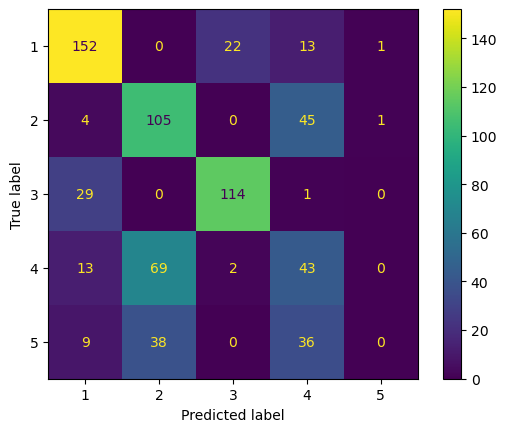

Accuracy Simple Deep Learning model:  0.593974175035868


In [168]:
y_pred_dl = np.argmax(y_pred_dl_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_dl)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_dl)
print("Accuracy Simple Deep Learning model: ", acc_dl)

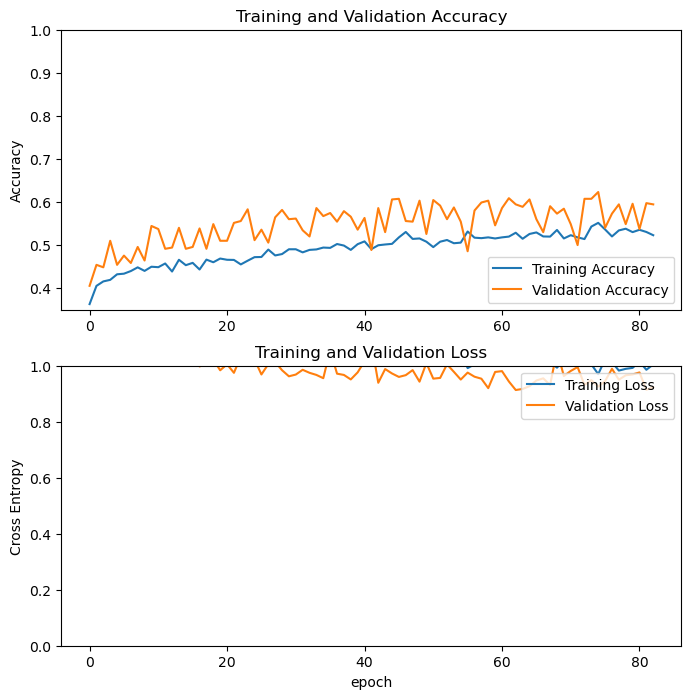

In [169]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [170]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

simple_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
simple_model.summary()
len(simple_model.trainable_variables)

Number of layers in the base model:  154
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 58320)             0         
                                                                 
 dense_27 (Dense)            (None, 128)               7465088   
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 6)                 774       
                                                                 
Total params: 7,465,862
Trainable params: 7,465,862
Non-trainable params: 0
_________________________________________________________________


4

In [171]:
fine_tune_epochs = 10
initial_epochs = max(history.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = simple_model.fit(X_train_nn2,Y_train,
                         epochs=total_epochs,callbacks=[EarlyStopping2],
                         initial_epoch=history.epoch[-1],
                         validation_data=(X_val_nn2,Y_val))

Epoch 83/92


/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-02-06 22:54:22.243595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - ETA: 0s - loss: 0.9455 - accuracy: 0.5532

2023-02-06 22:54:24.922970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 3s 31ms/step - loss: 0.9455 - accuracy: 0.5532 - val_loss: 0.9215 - val_accuracy: 0.5940
Epoch 84/92
87/87 [==============================] - 2s 27ms/step - loss: 0.9403 - accuracy: 0.5607 - val_loss: 0.9214 - val_accuracy: 0.5940
Epoch 85/92
87/87 [==============================] - 2s 27ms/step - loss: 0.9573 - accuracy: 0.5517 - val_loss: 0.9197 - val_accuracy: 0.6040
Epoch 86/92
87/87 [==============================] - 2s 28ms/step - loss: 0.9359 - accuracy: 0.5568 - val_loss: 0.9217 - val_accuracy: 0.5997
Epoch 87/92
87/87 [==============================] - 2s 27ms/step - loss: 0.9399 - accuracy: 0.5568 - val_loss: 0.9223 - val_accuracy: 0.6011
Epoch 88/92
87/87 [==============================] - 2s 27ms/step - loss: 0.9467 - accuracy: 0.5514 - val_loss: 0.9247 - val_accuracy: 0.5997
Epoch 89/92
87/87 [==============================] - 2s 28ms/step - loss: 0.9352 - accuracy: 0.5568 - val_loss: 0.9226 - val_accuracy: 0.6055
Epoch 90/92
87/87 

In [172]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

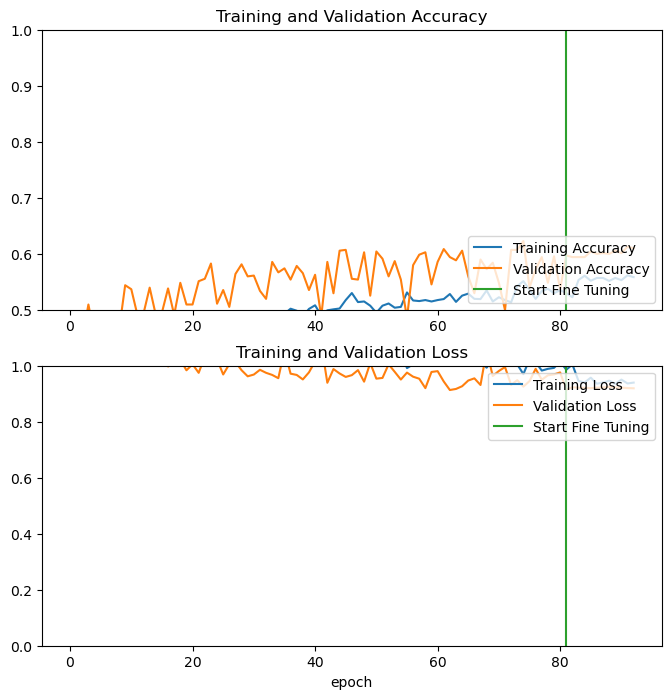

In [173]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [175]:
loss, accuracy = simple_model.evaluate(X_val_nn2,Y_val)
print('Test accuracy :', accuracy)

22/22 [==============================] - 0s 20ms/step - loss: 0.9193 - accuracy: 0.6098
Test accuracy : 0.6097561120986938


# Step 5. Convolutional Neural Networks (CNNs) classification

Convolutional Neural Networks (CNNs): These are commonly used for image classification tasks and have been shown to be effective for tree species classification using Sentinel-2 imagery.

In [182]:
CNNs_model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=input_size),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(128, (1,1), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16)
    
]
)

In [183]:

CNNs_model.summary() 

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 36, 36, 32)        12992     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 18, 18, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 18, 18, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 9, 9, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 9, 9, 128)         8320      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 4, 4, 128)      

In [184]:

CNNs_model.add(layers.Flatten())
CNNs_model.add(layers.Dense(64, activation='relu'))
CNNs_model.add(layers.Dropout(0.5))
CNNs_model.add(layers.Dense(output_size))

In [185]:

CNNs_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 36, 36, 32)        12992     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 18, 18, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 18, 18, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 9, 9, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 9, 9, 128)         8320      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 4, 4, 128)      

In [186]:

CNNs_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = CNNs_model.fit(X_train_nn2, Y_train, epochs=50,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=10),EarlyStopping2],  verbose=0,
                    validation_data=(X_val_nn2, Y_val))
     

Epoch 1/50


2023-02-06 22:57:16.728124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 22:57:18.979613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 3s 33ms/sample - loss: 1.3969 - accuracy: 0.3560 - val_loss: 1.0851 - val_accuracy: 0.4290
Epoch 11/50
87/87 [==============================] - 1s 15ms/sample - loss: 0.8124 - accuracy: 0.6114 - val_loss: 0.8639 - val_accuracy: 0.6255
Epoch 21/50
87/87 [==============================] - 1s 16ms/sample - loss: 0.6629 - accuracy: 0.7037 - val_loss: 0.7124 - val_accuracy: 0.7044
Epoch 31/50
87/87 [==============================] - 1s 14ms/sample - loss: 0.5400 - accuracy: 0.7906 - val_loss: 0.6850 - val_accuracy: 0.7174


In [187]:
y_pred_cnn_p = CNNs_model.predict(X_val_nn2)

print("Prediction example: ", y_pred_cnn_p[0,:], " Class: ", np.argmax(y_pred_cnn_p[0,:]))

 2/22 [=>............................] - ETA: 1s

2023-02-06 22:59:40.576360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 15ms/step
Prediction example:  [-12.10599     6.401065   -4.5003257   1.3911284  -2.7236962  -6.4052486]  Class:  1


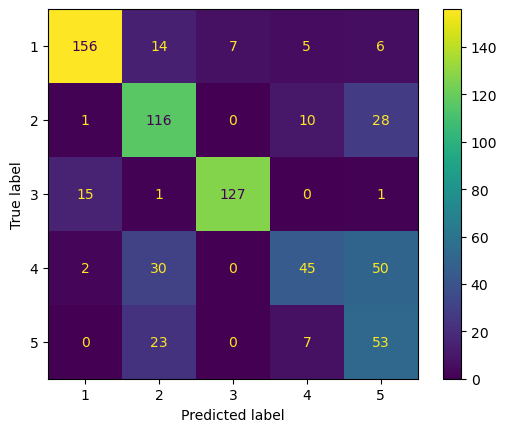

Accuracy Simple Deep Learning model:  0.7130559540889526


In [188]:
y_pred_cnn = np.argmax(y_pred_cnn_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_cnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_cnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)

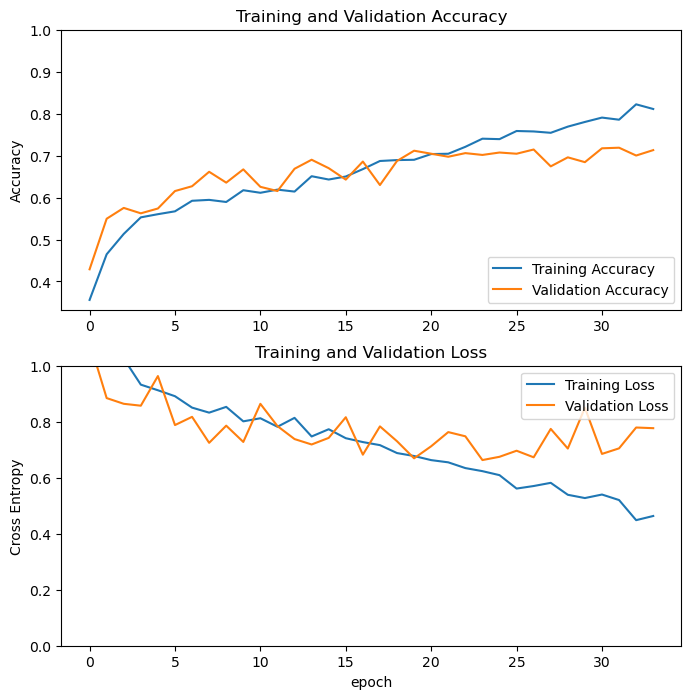

In [189]:

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [190]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

CNNs_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
CNNs_model.summary()
len(CNNs_model.trainable_variables)

Number of layers in the base model:  154
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 36, 36, 32)        12992     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 18, 18, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 18, 18, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 9, 9, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 9, 9, 128)         8320      
                                                                 
 max_pooling

14

In [191]:

fine_tune_epochs = 10
initial_epochs = max(history2.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = CNNs_model.fit(X_train_nn2,Y_train,
                         epochs=total_epochs,callbacks=EarlyStopping3,
                         initial_epoch=history2.epoch[-1],
                         validation_data=(X_val_nn2,Y_val))

Epoch 34/43


2023-02-06 23:00:15.244444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


85/87 [============================>.] - ETA: 0s - loss: 0.3767 - accuracy: 0.8526

2023-02-06 23:00:18.034649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 4s 29ms/step - loss: 0.3757 - accuracy: 0.8538 - val_loss: 0.7292 - val_accuracy: 0.7202
Epoch 35/43
87/87 [==============================] - 2s 18ms/step - loss: 0.3480 - accuracy: 0.8675 - val_loss: 0.7076 - val_accuracy: 0.7260
Epoch 36/43
87/87 [==============================] - 2s 18ms/step - loss: 0.3383 - accuracy: 0.8732 - val_loss: 0.7019 - val_accuracy: 0.7346
Epoch 37/43
87/87 [==============================] - 2s 20ms/step - loss: 0.3306 - accuracy: 0.8768 - val_loss: 0.7051 - val_accuracy: 0.7360
Epoch 38/43
87/87 [==============================] - 1s 17ms/step - loss: 0.3312 - accuracy: 0.8754 - val_loss: 0.7034 - val_accuracy: 0.7360
Epoch 39/43
87/87 [==============================] - 2s 18ms/step - loss: 0.3235 - accuracy: 0.8779 - val_loss: 0.7054 - val_accuracy: 0.7360


In [192]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

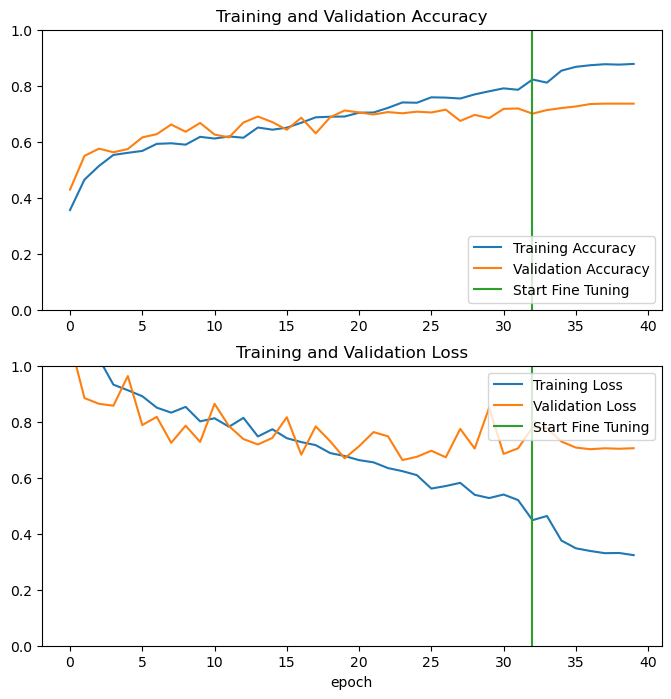

In [193]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [194]:
loss, accuracy = CNNs_model.evaluate(X_val_nn2,Y_val)
print('Test accuracy :', accuracy)

22/22 [==============================] - 0s 13ms/step - loss: 0.7054 - accuracy: 0.7360
Test accuracy : 0.7360115051269531


# Step 6. - Residual Network: ResNet

A residual neural network (ResNet) is an artificial neural network that imitate the pyramidal cells in the cerebral cortex. Particularly, the ResNet architecture consists of skip connections or shortcuts to jump over some layers. Typical ResNet models are implemented with double- or triple- layer skips that contain nonlinearities (ReLU) and batch normalization in between. These *cells* are known as *residual block*.

ResNets connection weights are easier to optimize (especially for gradient descent-based optimizers) because the short cuts contribute to alleviate the vanishing gradient problem.

In practice, the degradation problem (i.e., increasing the depth of a network leads to a decrease in its performance) is mitigated, and the observed performance (when the number of hidden layers increase) is much closer to the theoretical one.

In [195]:
model_rn = tf.keras.applications.resnet50.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=input_size, 
    pooling=None,
    classes=output_size)

model_rn.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/applications/resnet.py:159: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 45 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


In [196]:
history3=model_rn.fit(X_train_nn2, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=10),EarlyStopping],  verbose=0,validation_data=(X_val_nn2, Y_val))


Epoch 1/100


2023-02-06 23:01:48.563769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 23:02:06.195706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 24s 275ms/sample - loss: 1.5812 - accuracy: 0.4910 - val_loss: 2.8496 - val_accuracy: 0.2066
Epoch 11/100
87/87 [==============================] - 7s 81ms/sample - loss: 0.6525 - accuracy: 0.7622 - val_loss: 0.9915 - val_accuracy: 0.6456
Epoch 21/100
87/87 [==============================] - 7s 84ms/sample - loss: 0.4087 - accuracy: 0.8427 - val_loss: 0.9400 - val_accuracy: 0.7030


22/22 [==============================] - 1s 27ms/step


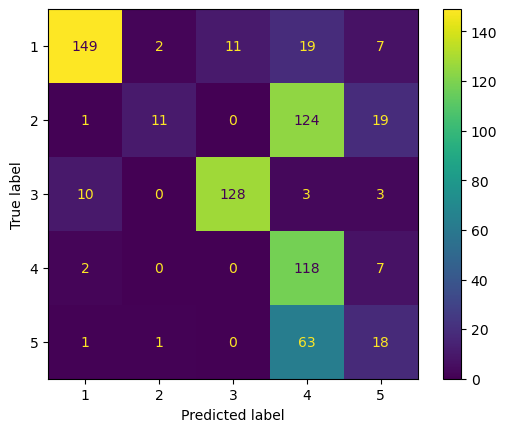

Accuracy ResNet-50 model:  0.6083213773314203


In [198]:
y_pred_rn_p = model_rn.predict(X_val_nn2)

y_pred_rn = np.argmax(y_pred_rn_p, axis=1)

##print(y_pred_rn)
#print(Y_val)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rn)
plt.show()

acc_rn = accuracy_score(Y_val, y_pred_rn)
print("Accuracy ResNet-50 model: ", acc_rn)

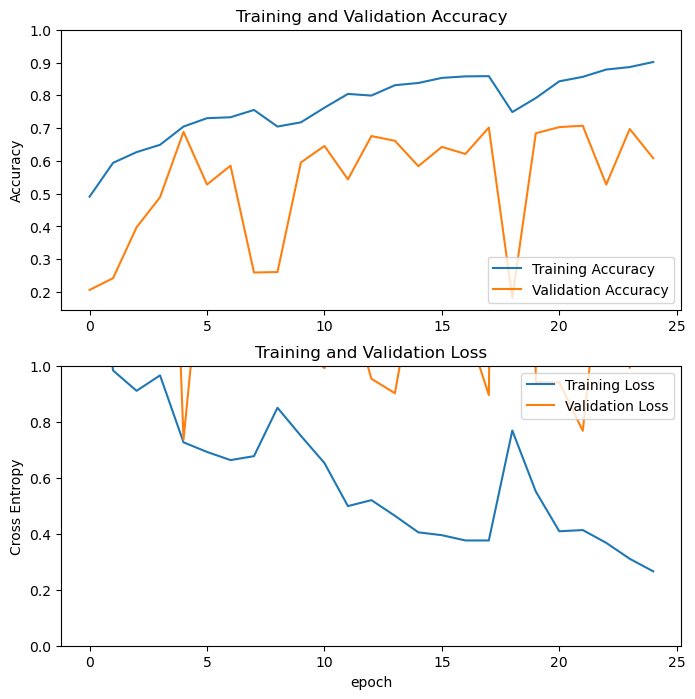

In [199]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [200]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model_rn.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model_rn.summary()
len(model_rn.trainable_variables)

Number of layers in the base model:  154
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 36, 36, 45)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 42, 42, 45)   0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 18, 18, 64)   141184      ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 18, 18, 64)

214

In [201]:
fine_tune_epochs = 10
initial_epochs = max(history3.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model_rn.fit(X_train_nn2,Y_train,
                         epochs=total_epochs, callbacks=EarlyStopping3,
                         initial_epoch=history3.epoch[-1],
                         validation_data=(X_val_nn2,Y_val))

Epoch 25/34


/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-02-06 23:05:56.778639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9501

2023-02-06 23:06:27.181109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 38s 246ms/step - loss: 0.1592 - accuracy: 0.9501 - val_loss: 0.7164 - val_accuracy: 0.7432
Epoch 26/34
87/87 [==============================] - 15s 175ms/step - loss: 0.1095 - accuracy: 0.9655 - val_loss: 0.7083 - val_accuracy: 0.7661
Epoch 27/34
87/87 [==============================] - 13s 150ms/step - loss: 0.0836 - accuracy: 0.9738 - val_loss: 0.7501 - val_accuracy: 0.7762
Epoch 28/34
87/87 [==============================] - 14s 166ms/step - loss: 0.0840 - accuracy: 0.9749 - val_loss: 0.7846 - val_accuracy: 0.7719
Epoch 29/34
87/87 [==============================] - 14s 167ms/step - loss: 0.0665 - accuracy: 0.9784 - val_loss: 0.8302 - val_accuracy: 0.7704
Epoch 30/34
87/87 [==============================] - 14s 159ms/step - loss: 0.0560 - accuracy: 0.9802 - val_loss: 0.8752 - val_accuracy: 0.7618


In [203]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

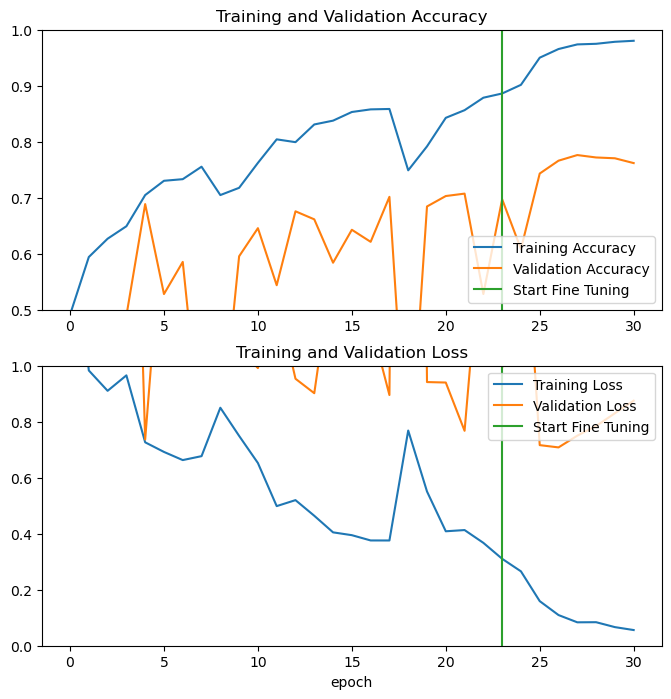

In [204]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [206]:
loss, accuracy = model_rn.evaluate(X_val_nn2,Y_val)
print('Test accuracy :', accuracy)

22/22 [==============================] - 1s 32ms/step - loss: 0.8752 - accuracy: 0.7618
Test accuracy : 0.7618364691734314


# Step 7. Recurrent Neural Networks (RNNs) classification

Recurrent Neural Networks (RNNs): RNNs can be used to analyze sequential data such as time series data, which can be useful for analyzing the temporal information present in Sentinel-2 imagery.

In [211]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = bands

units = 64


# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(kernel*kernel, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(kernel*kernel, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model

In [212]:
RNNs_model = build_model(allow_cudnn_kernel=True)

RNNs_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


history5=RNNs_model.fit(
    X_train_nn, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=10),EarlyStopping],  verbose=0, validation_data=(X_val_nn, Y_val), batch_size=batch_size
)

Epoch 1/100


2023-02-06 23:10:34.695364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 23:10:34.948671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 23:10:37.209548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 23:11:04.534562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 23:11:04.723005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 36s 810ms/sample - loss: 1.5597 - accuracy: 0.3912 - val_loss: 1.7640 - val_accuracy: 0.2726
Epoch 11/100
44/44 [==============================] - 9s 213ms/sample - loss: 1.0598 - accuracy: 0.5830 - val_loss: 2.2800 - val_accuracy: 0.2912
Epoch 21/100
44/44 [==============================] - 9s 210ms/sample - loss: 1.0115 - accuracy: 0.5894 - val_loss: 1.5260 - val_accuracy: 0.4706
Epoch 31/100
44/44 [==============================] - 9s 206ms/sample - loss: 0.9923 - accuracy: 0.6006 - val_loss: 1.5743 - val_accuracy: 0.5280
Epoch 41/100
44/44 [==============================] - 10s 216ms/sample - loss: 0.9474 - accuracy: 0.6203 - val_loss: 3.3479 - val_accuracy: 0.3730


In [213]:
y_pred_rnn_p = RNNs_model.predict(X_val_nn)

print("Prediction example: ", y_pred_rnn_p[0,:], " Class: ", np.argmax(y_pred_rnn_p[0,:]))

2023-02-06 23:18:37.382897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 23:18:37.480043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 6s 194ms/step
Prediction example:  [-0.03440529 -1.2239833  -1.0694274  11.163738   -5.9245014  -1.9552662 ]  Class:  3


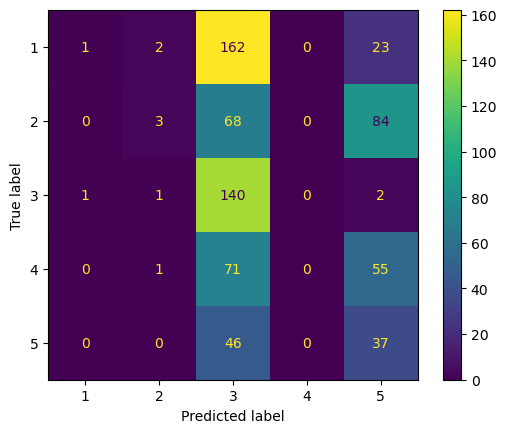

Accuracy Simple Deep Learning model:  0.25968436154949787


In [214]:
y_pred_rnn = np.argmax(y_pred_rnn_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_rnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)

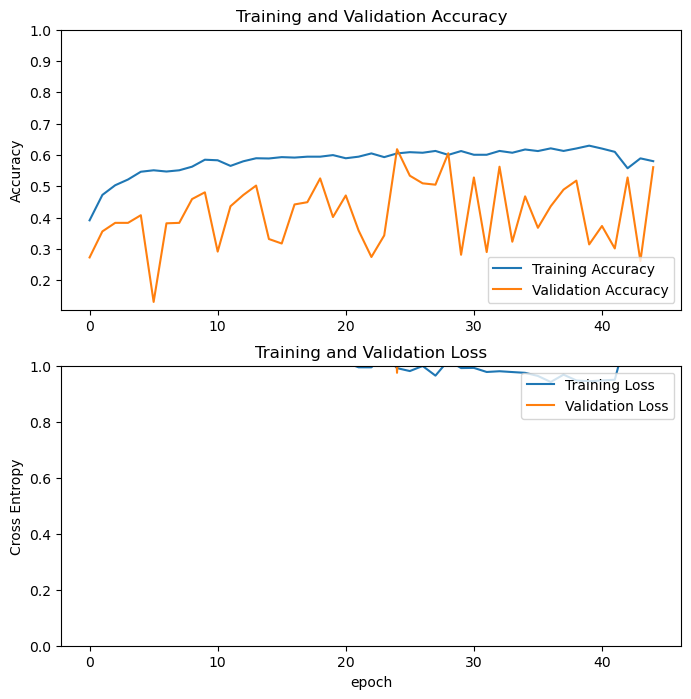

In [215]:

acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [216]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

RNNs_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
RNNs_model.summary()
len(RNNs_model.trainable_variables)

Number of layers in the base model:  154
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                28160     
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_39 (Dense)            (None, 6)                 390       
                                                                 
Total params: 28,806
Trainable params: 28,678
Non-trainable params: 128
_________________________________________________________________


7

In [217]:
fine_tune_epochs = 15
initial_epochs = max(history5.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = RNNs_model.fit(X_train_nn,Y_train,
                         epochs=total_epochs, callbacks=EarlyStopping2,
                         initial_epoch=history5.epoch[-1],
                         validation_data=(X_val_nn,Y_val))

Epoch 45/54


2023-02-06 23:18:57.594895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 23:18:57.823145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 23:19:00.163079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - ETA: 0s - loss: 1.0886 - accuracy: 0.5575

2023-02-06 23:19:22.395911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 23:19:22.541069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 31s 254ms/step - loss: 1.0886 - accuracy: 0.5575 - val_loss: 1.5753 - val_accuracy: 0.4161
Epoch 46/54
87/87 [==============================] - 18s 204ms/step - loss: 1.0393 - accuracy: 0.5722 - val_loss: 1.0857 - val_accuracy: 0.5481
Epoch 47/54
87/87 [==============================] - 17s 200ms/step - loss: 1.0210 - accuracy: 0.5851 - val_loss: 0.9812 - val_accuracy: 0.6126
Epoch 48/54
87/87 [==============================] - 17s 199ms/step - loss: 1.0059 - accuracy: 0.5934 - val_loss: 0.9528 - val_accuracy: 0.6327
Epoch 49/54
87/87 [==============================] - 17s 199ms/step - loss: 0.9986 - accuracy: 0.5916 - val_loss: 0.9435 - val_accuracy: 0.6313
Epoch 50/54
87/87 [==============================] - 17s 199ms/step - loss: 0.9954 - accuracy: 0.5995 - val_loss: 0.9370 - val_accuracy: 0.6341
Epoch 51/54
87/87 [==============================] - 18s 207ms/step - loss: 0.9880 - accuracy: 0.6002 - val_loss: 0.9321 - val_accuracy: 0.6370
Epoc

In [218]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

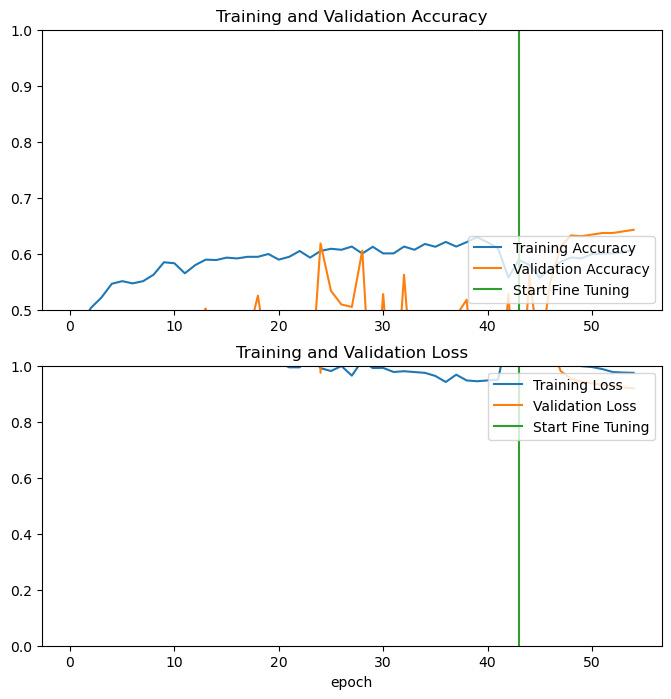

In [219]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [220]:
loss, accuracy = RNNs_model.evaluate(X_val_nn,Y_val)
print('Test accuracy :', accuracy)

22/22 [==============================] - 2s 111ms/step - loss: 0.9190 - accuracy: 0.6428
Test accuracy : 0.6427546739578247


# Step 8. Decision fusion for deep learning methods

In [221]:
def normalized(data):

    normalizedData = data/np.linalg.norm(data)
    return normalizedData

In [222]:

y_pred_dl_p_2 = simple_model.predict(X_val_nn2)
y_pred_cnn_p_2 = CNNs_model.predict(X_val_nn2)
y_pred_rn_p_2 = model_rn.predict(X_val_nn2)
y_pred_rnn_p_2 = RNNs_model.predict(X_val_nn)

 5/22 [=====>........................] - ETA: 0s

2023-02-06 23:22:50.518611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 1s 22ms/step


2023-02-06 23:22:51.397497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 1s 13ms/step


2023-02-06 23:22:52.464203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 4s 91ms/step


2023-02-06 23:22:56.285893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 23:22:56.389559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 6s 193ms/step


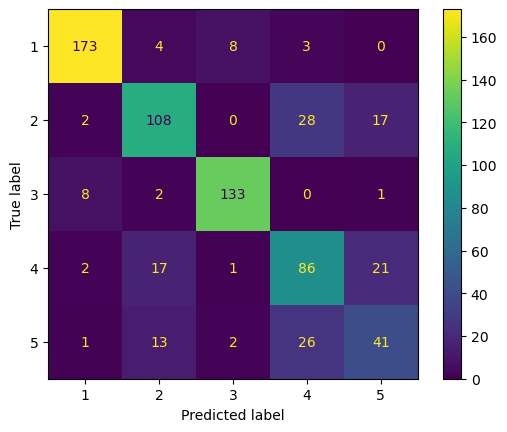

Accuracy Simple Deep Learning model:  0.776183644189383


In [227]:

#fusion"""y_pred_dl_p_2 +
fusion_softmax = normalized(y_pred_cnn_p_2) + normalized(y_pred_rn_p_2) + normalized(y_pred_rnn_p_2)
fusion_label = np.argmax(fusion_softmax,axis=1).astype(np.int16)
ConfusionMatrixDisplay.from_predictions(Y_val, fusion_label)
plt.show()

acc_dl = accuracy_score(Y_val, fusion_label)
print("Accuracy Simple Deep Learning model: ", acc_dl)

# Step 9. Test data prediction

16/16 [==============================] - 4s 231ms/step


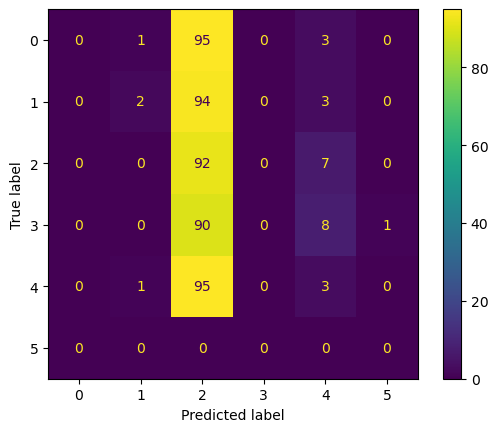

Accuracy Simple Deep Learning model:  0.19595959595959597


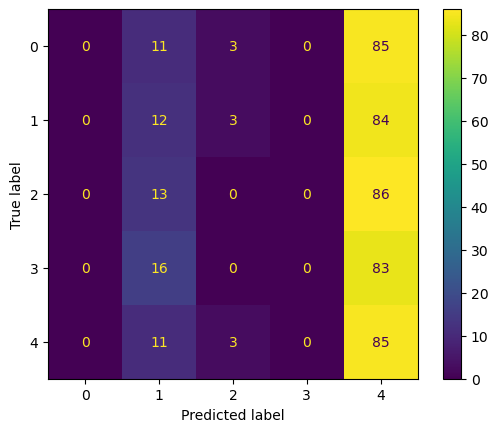

Accuracy Convolutional Neural Network model:  0.19595959595959597


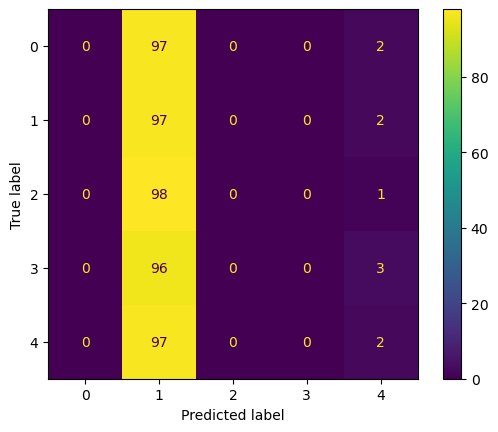

Accuracy Resnet50 model:  0.2


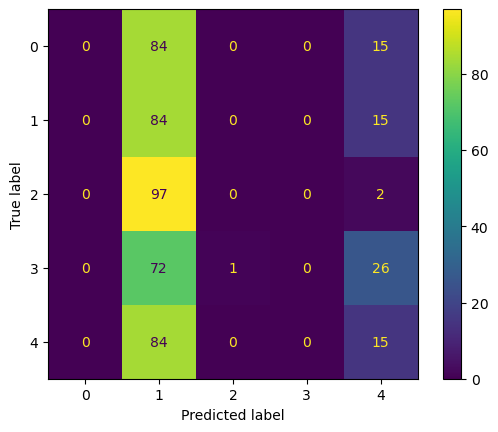

Accuracy RNN model:  0.2


In [224]:
y_pred_dl_p_3 = simple_model.predict(X_test_nn2)
y_pred_cnn_p_3 = CNNs_model.predict(X_test_nn2)
y_pred_rn_p_3 = model_rn.predict(X_test_nn2)
y_pred_rnn_p_3 = RNNs_model.predict(X_test_nn)
y_pred_dl_3 = np.argmax(y_pred_dl_p_3,axis=1).astype(np.int16)
y_pred_cnn_3 = np.argmax(y_pred_cnn_p_3,axis=1).astype(np.int16)
y_pred_rn_3 = np.argmax(y_pred_rn_p_3,axis=1).astype(np.int16)
y_pred_rnn_3 = np.argmax(y_pred_rnn_p_3,axis=1).astype(np.int16)

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred_dl_3)
plt.show()
acc_dl_3 = accuracy_score(Y_test, y_pred_dl_3)
print("Accuracy Simple Deep Learning model: ", acc_dl_3)

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred_cnn_3)
plt.show()
acc_cnn_3 = accuracy_score(Y_test, y_pred_cnn_3)
print("Accuracy Convolutional Neural Network model: ", acc_cnn_3)

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred_rn_3)
plt.show()
acc_rn_3 = accuracy_score(Y_test, y_pred_rn_3)
print("Accuracy Resnet50 model: ", acc_rn_3)

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred_rnn_3)
plt.show()
acc_rnn_3 = accuracy_score(Y_test, y_pred_rnn_3)
print("Accuracy RNN model: ", acc_rnn_3)

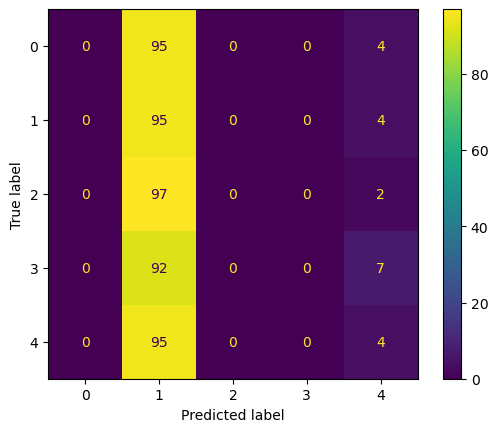

Accuracy Simple Deep Learning model:  0.2


In [225]:
#fusion"""y_pred_dl_p_2 +
fusion_softmax_t = normalized(y_pred_cnn_p_3)  + normalized(y_pred_rn_p_3) + normalized(y_pred_rnn_p_3)
fusion_label_t = np.argmax(fusion_softmax_t,axis=1).astype(np.int16)
ConfusionMatrixDisplay.from_predictions(Y_test, fusion_label_t)
plt.show()

acc_dl = accuracy_score(Y_test, fusion_label_t)
print("Accuracy Simple Deep Learning model: ", acc_dl)